#  NEURAL NETWORK ARCHITECTURE :

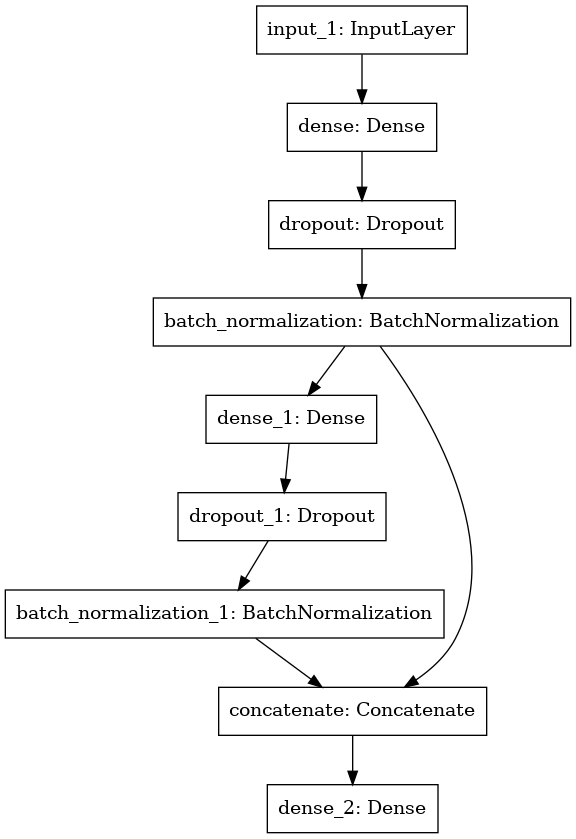

### Update : Alexander Ryzhkov's with several rounds of training for more stable prdictions

In [ ]:
import pandas as pd
import numpy as np

import os, gc
import warnings
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display
from scipy.optimize import minimize

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer,MinMaxScaler, QuantileTransformer, KBinsDiscretizer
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization, Embedding, Conv1D, Flatten

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

from colorama import Fore, Back, Style
from pathlib import Path

## Load features

In [ ]:
path=Path('/kaggle/input/tabular-playground-series-nov-2022/')

In [ ]:
target = pd.read_csv('../input/tabular-playground-series-nov-2022/train_labels.csv',usecols= ['label'])
subs=sorted(os.listdir(path/'submission_files'))
s0=pd.read_csv(path/'submission_files'/ subs[0], index_col='id')

X_train=np.zeros((s0.shape[0], len(subs)))
for i, name in enumerate(subs):
    sub=pd.read_csv(path/'submission_files'/name, index_col='id')
    X_train[:,i]=sub.pred.values
X_train=pd.DataFrame(X_train, columns=subs)

In [ ]:
X_train

In [ ]:
X_train=X_train.clip(0.0000001,0.99999999)

In [ ]:
pca=TruncatedSVD()
pca_sample=pca.fit_transform(X_train)
total=sum(pca.explained_variance_)
k=0
var=0.98
current_var=0
while current_var/total <= var:
    current_var +=pca.explained_variance_[k]
    k=k+1
print(F"{var*100:.0f}% explained_variance with {k}/{len(X_train.columns)}features")

In [ ]:
pca=TruncatedSVD(n_components=128)

In [ ]:
pca_data=pca.fit_transform(X_train)

In [ ]:
pca_data.shape

In [ ]:
X=pca_data

In [ ]:
X.shape

In [ ]:
st = StandardScaler()
X_st = st.fit_transform(X)

In [ ]:
X=X_st[:20000]
test=X_st[20000:]

In [ ]:
X.shape

In [ ]:
test.shape

In [ ]:
Y=target
Y.shape

## Neural Network training parameters

In [ ]:
plateau = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.95, 
        patience=3, 
        verbose=1,
        mode='min')


## Training history display

## Model definition

In [ ]:
def create_model():
    reg1 = 1e-06
    reg2 = 1e-07 
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    UNITS = 128
    DROP = 0.3
    activation = tfa.activations.mish 
    
    inputs = Input(shape=(X.shape[1],))

    x0 = Dense(UNITS, 
               kernel_regularizer=REG1,
               activation=activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    x0 = BatchNormalization()(x0)
    
    x1 = Dense(UNITS, 
               kernel_regularizer=REG1,
               activation=activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    x1 = BatchNormalization()(x1)
    
    x2 = Concatenate()([
                        x0, 
                        x1
                      ])
    x2 = Dense(UNITS, 
               kernel_regularizer=REG1,
               activation=activation,
             )(x2)
    x2 = Dropout(DROP)(x2)
    x2 = BatchNormalization()(x2)
    x3 = Dense(UNITS, 
               kernel_regularizer=REG1,
               activation=activation,
             )(x2)
    x3 = Dropout(DROP)(x3)
    x3 = BatchNormalization()(x3)
    x= Concatenate()([
                        x0, 
                        x1,x2,x3
                      ])
    x = Dense(1, 
              kernel_regularizer=REG2,
              activation='sigmoid',
             )(x)
    
    model = Model(inputs, x)    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=tf.keras.metrics.BinaryCrossentropy())
    
    return model

## Training and prediction

In [ ]:
Y=Y.values

In [ ]:
Y.shape

In [ ]:
 tf.keras.backend.clear_session()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
i=0
N_SPLIT = 12
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
print("--------------" + str(i) + "th iteration-----------------------------")
for fold,(idx_tr, idx_va) in enumerate(kf.split(X,Y)):
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    X_va = X[idx_va]
    y_va = Y[idx_va]
    model=create_model()
    tf.keras.backend.clear_session()
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',min_delta=1e-10,
                                                    restore_best_weights=True,patience=20),
                   tf.keras.callbacks.ModelCheckpoint(f'best_model{fold}.h5', monitor='val_loss',
                                                      save_best_only=True, save_weights_only=True,
                                                      verbose=1)]
    history=model.fit(X_tr,
              y_tr,
              validation_data=(X_va,y_va),
              epochs =1000,
              verbose=0,
              batch_size=256,
              callbacks=[callbacks,plateau]
             )


#### We can see the mean of oof predictions from rounds provides better oof score (in red)

## Calibration control

In [ ]:
fold_preds = []
for fold in range(12):
    tf.keras.backend.clear_session()
    model = create_model()
    model.load_weights(f'best_model{fold}.h5')
    print(f'\nFold {fold} inference...')
    pred = model.predict(test, batch_size=256)
    fold_preds.append(pred)
    gc.collect()

In [ ]:
preds = np.mean(fold_preds, axis=0)
preds.shape

In [ ]:
sub_df = pd.read_csv('../input/tabular-playground-series-nov-2022/sample_submission.csv')
sub_df['pred']=preds

In [ ]:
sub_df.set_index('id', inplace=True)

In [ ]:
sub_df.to_csv('submission.csv') 